<a href="https://colab.research.google.com/github/amien1410/kaggle-projects/blob/main/Foreign_objects_in_Chest_XRays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Install Kaggle Modules to download the dataset
!pip install kaggle

# Load Kaggle user authorization key
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download the dataset, get the user and dataset name from the url "https://www.kaggle.com/datasets/shivamb/netflix-shows"
!kaggle datasets download -d raddar/foreign-objects-in-chest-xrays

# Unzip the dataset
!unzip -q "/content/foreign-objects-in-chest-xrays"

In [4]:
#@title Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

In [5]:
#@title Dataset Preparation
train_df = pd.read_csv('/content/object-CXR/train.csv')
train_df.head()

,image_name,annotation
0,00001.jpg,NaN
1,00002.jpg,NaN
2,00003.jpg,NaN
3,00004.jpg,NaN
4,00005.jpg,0 2076 1559 2369 1695


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  8000 non-null   object
 1   annotation  4000 non-null   object
dtypes: object(2)
memory usage: 125.1+ KB


In [7]:
train_df.isnull().sum()

,0
image_name,0
annotation,4000


In [8]:
train_df = train_df.dropna()
train_df = train_df.reset_index()
del train_df['index']
train_df.head()

,image_name,annotation
0,00005.jpg,0 2076 1559 2369 1695
1,00006.jpg,0 1368 2587 1692 3039
2,00007.jpg,0 944 188 2064 806
3,00008.jpg,0 730 1720 1897 2673
4,00009.jpg,0 847 1346 1345 1877


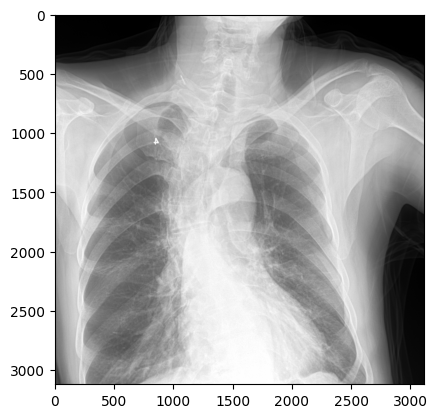

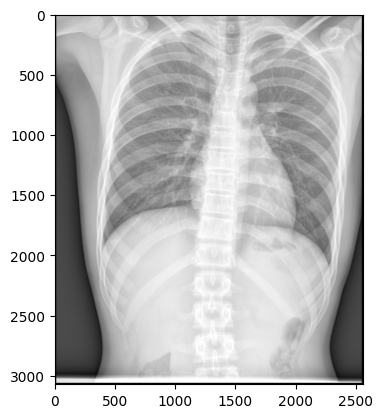

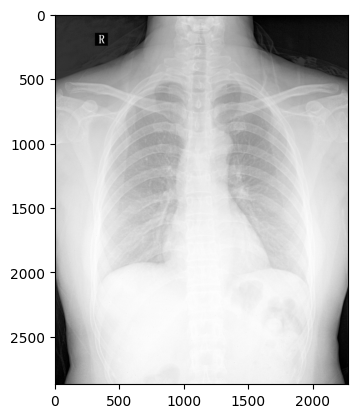

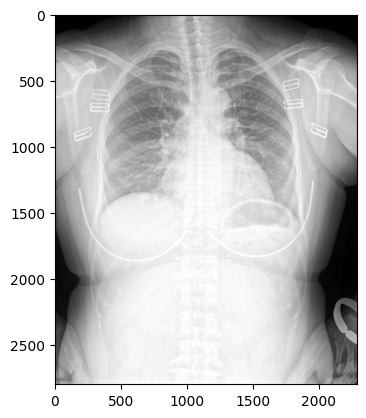

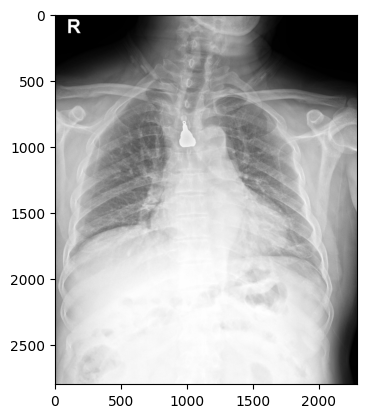

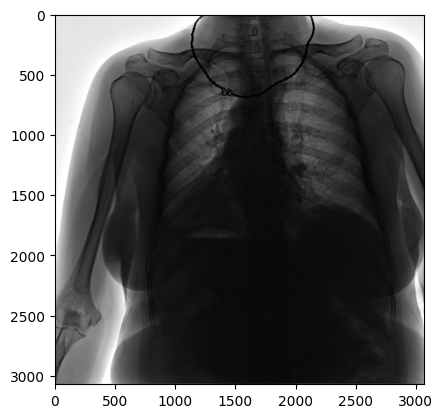

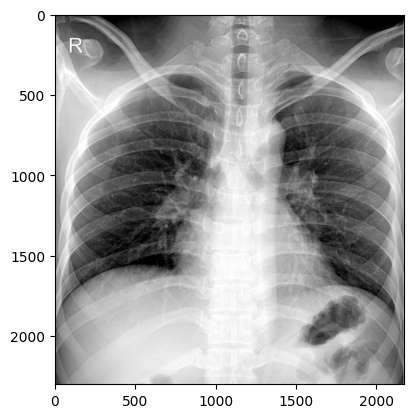

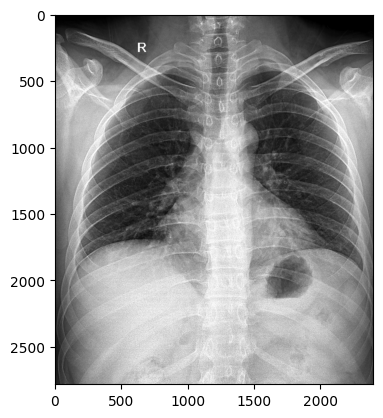

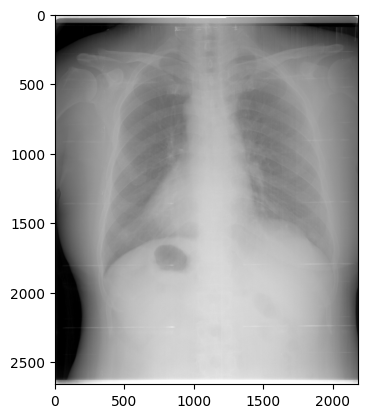

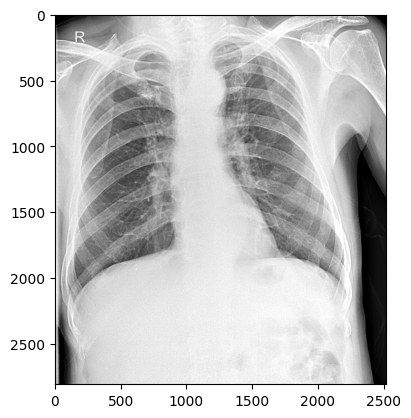

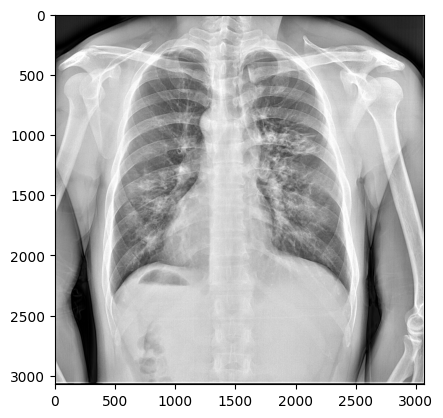

In [12]:
#@title Visualize the image
shape = []
TRAIN_IMG_PATH = r'/content/object-CXR/train'
for i, img in enumerate(os.listdir(TRAIN_IMG_PATH)):
    image = os.path.join(TRAIN_IMG_PATH, img)
    image = cv2.imread(image, (cv2.COLOR_RGB2GRAY))
    plt.imshow(image)
    plt.show()
    shape.append(image.shape)
    if i == 10:
        break

In [13]:
shape

[(3120, 3120, 3),
 (3072, 2560, 3),
 (2868, 2274, 3),
 (2800, 2288, 3),
 (2800, 2288, 3),
 (3072, 3072, 3),
 (2300, 2172, 3),
 (2784, 2400, 3),
 (2660, 2180, 3),
 (2810, 2514, 3),
 (3072, 3072, 3)]

(3065, 2552, 3)


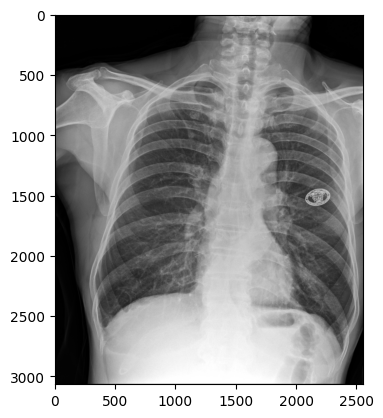

In [14]:
#@title Draw the Annotation box of the image
IMG_SHAPE = (640, 480)
img = train_df.iloc[8]['image_name']
anno = train_df.iloc[8]['annotation']

image = cv2.imread(os.path.join(TRAIN_IMG_PATH,img), cv2.COLOR_RGB2GRAY)
#image = cv2.resize(image, (640,640))
print(image.shape)
plt.imshow(image)

In [15]:
def conv_str2annot(anno):
    anno = anno.split(' ')
    annotation = []

    for i in anno:
        annotation.append(int(i))

    return annotation
def find_coord(anno):

    annotation = anno
    coordinates = [0, 0, 0, 0]

    x1 = coordinates[0] = annotation[1]
    y1 = coordinates[1] = annotation[2]
    x2 = coordinates[2] = annotation[3]
    y2 = coordinates[3] = annotation[4]

    #print(coordinates)
    return [x1, y1, x2,y2]

coordinate = conv_str2annot(anno)
coordinate = find_coord(coordinate)
coordinate

[2045, 1415, 2324, 1594]

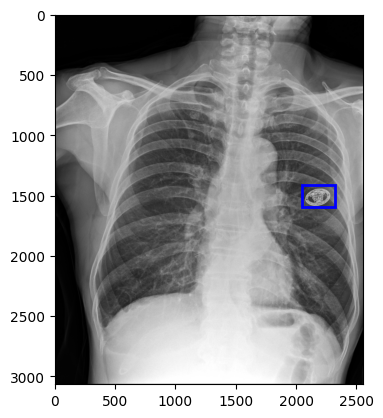

In [17]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[0], boxes[1], boxes[2], boxes[3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = tf.stack((cx, cy, w, h), axis=-1)
    return np.array(boxes)

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[0], boxes[1], boxes[2], boxes[3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return np.array(boxes)

def check_bbox_val(coordinates):
    boxes = tf.constant((coordinates))
    box_center_to_corner(box_corner_to_center(coordinates)) == boxes
    return boxes

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

fig = plt.imshow(image)
fig.axes.add_patch(bbox_to_rect(coordinate, 'blue'))

In [18]:
coordinates = []
for annot in train_df['annotation'][:5]:
    coord = annot.split(' ')
    anno = []
    for i in coord:
        anno.append(int(i))
    coordinates.append(anno)

coordinates

[[0, 2076, 1559, 2369, 1695],
 [0, 1368, 2587, 1692, 3039],
 [0, 944, 188, 2064, 806],
 [0, 730, 1720, 1897, 2673],
 [0, 847, 1346, 1345, 1877]]

In [19]:
train_df[:5]

,image_name,annotation
0,00005.jpg,0 2076 1559 2369 1695
1,00006.jpg,0 1368 2587 1692 3039
2,00007.jpg,0 944 188 2064 806
3,00008.jpg,0 730 1720 1897 2673
4,00009.jpg,0 847 1346 1345 1877


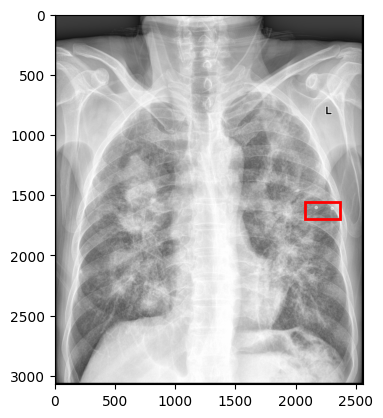

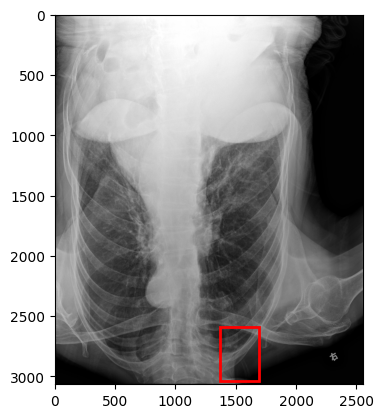

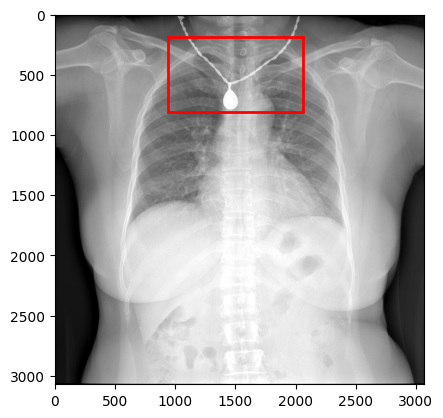

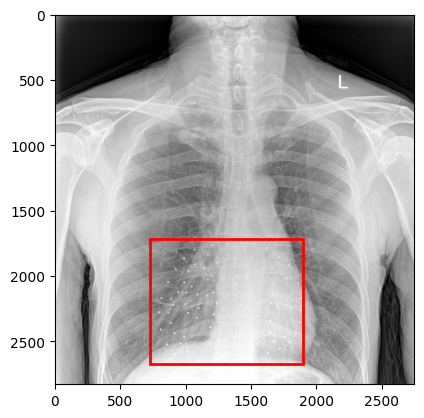

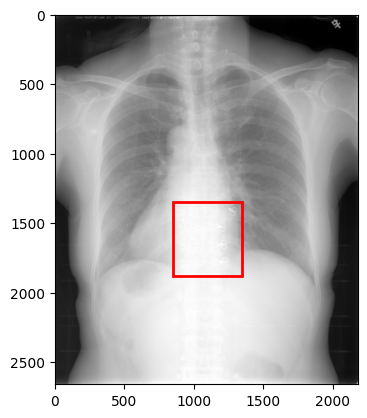

In [20]:
coordinates_1 = []

for i in coordinates:
    coordinates_1.append(find_coord(i))

for idx,img in enumerate(train_df['image_name'][:5]):
    image = cv2.imread(os.path.join(TRAIN_IMG_PATH, img), cv2.COLOR_RGB2GRAY)
    fig = plt.imshow(image)
    fig.axes.add_patch(bbox_to_rect(coordinates_1[idx], 'red'))
    plt.show()